<a href="https://colab.research.google.com/github/senthilkumar-dimitra/LULC-Classification-DL/blob/main/LULC_classification_Magdalena_using_Polygons_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install rasterio -q
!pip install earthpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.9 MB/s eta 0:00:00


In [3]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [31]:
# Parameter
FEATURES = ['VV', 'VH','B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9','B11', 'B12', 'ndvi', 'ndbi', 'mndwi', 'ndwi', 'bsi', 'evi', 'elev', 'slope'] # 'ndvi', 'ndbi', 'mndwi', 'ndwi', 'bsi', 'evi', 'elev'
LABEL = ['class']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [0, 1, 2, 3, 4, 5]
PALETTE = ['006400', 'f096ff', '42c447', 'b5ac89', 'ffff4c', '0064c8']
SAMPLE_PATH = '/content/drive/MyDrive/s1s2_magdalena/Samples_LC_Magdalena_2020_polys.csv'
IMAGE_PATH = '/content/drive/MyDrive/s1s2_magdalena/S1S2_Magdalena_2020.tif'

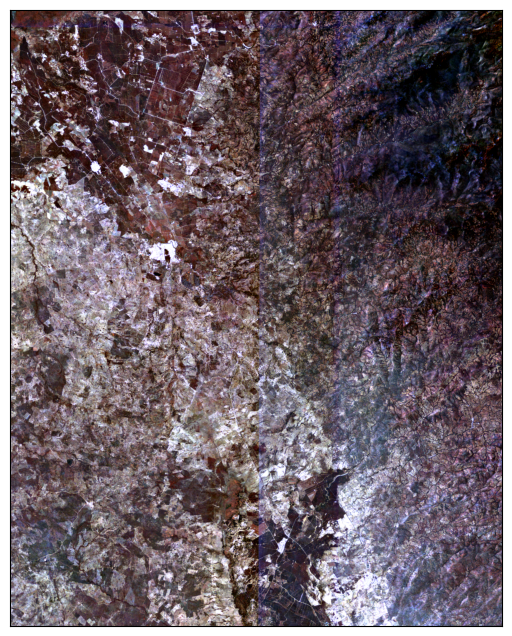

<Axes: >

In [32]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [5,4,3]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [33]:
bandNum

22

In [34]:
len(FEATURES)

22

In [35]:
bandNum == len(FEATURES)

True

In [36]:
transform

Affine(0.00026949458523585647, 0.0, -74.36379686081176,
       0.0, -0.00026949458523585647, 10.785712290309448)

In [37]:
crs

CRS.from_epsg(4326)

In [38]:
# Read sample
pd.set_option('display.max_columns', None)
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples.head()

,VV,VH,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,ndvi,ndbi,mndwi,ndwi,bsi,evi,elev,slope,class,sample
142,-7.179941,-14.286389,228.0,277.5,585.0,322.0,1005.5,2809.0,3547.5,3604.5,3827.5,3802.5,2148.0,973.0,0.835986,-0.253194,-0.571899,-0.720730,-0.222292,2.374322,54,0.927410,0,train
32,-7.306563,-13.520511,272.0,301.0,593.0,309.0,1012.0,2401.0,2944.0,2985.0,3291.0,3480.0,2263.0,994.0,0.812386,-0.137576,-0.584734,-0.668530,-0.121885,2.590513,125,0.927410,0,train
631,-9.251564,-14.605469,487.0,605.5,903.0,831.5,1376.0,2574.5,2951.0,3050.5,3417.5,3441.0,3284.0,2055.0,0.571613,0.036862,-0.568665,-0.543190,0.059126,1.585340,53,2.101234,1,test
721,-7.399352,-14.855116,256.0,285.0,582.0,399.0,1021.0,2800.0,3447.0,3438.0,3775.0,3554.0,1995.0,932.0,0.792025,-0.265599,-0.548312,-0.710448,-0.217263,2.055879,24,0.000000,2,train
466,-8.286454,-14.146741,417.0,500.0,892.5,638.0,1495.0,2772.0,3177.5,3132.5,3514.0,3423.5,2649.0,1310.0,0.661583,-0.083629,-0.495976,-0.556522,-0.049931,1.941850,985,40.138050,1,train


In [39]:
# Count NaN values in each column
nan_count_per_column = samples.isna().sum()

# Count total NaN values
total_nan_count = samples.isna().any(axis=1).sum()

print("NaN count per column:")
print(nan_count_per_column)

print("Total NaN count:", total_nan_count)


NaN count per column:
VV        0
VH        0
B1        0
B2        0
B3        0
B4        0
B5        0
B6        0
B7        0
B8        0
B8A       0
B9        0
B11       0
B12       0
ndvi      0
ndbi      0
mndwi     0
ndwi      0
bsi       0
evi       0
elev      0
slope     0
class     0
sample    0
dtype: int64
Total NaN count: 0


In [40]:
samples.shape

(883, 24)

In [41]:
class_counts = samples['class'].value_counts()
total_rows = samples.shape[0]

for class_label, count in class_counts.items():
  print(f"Class {class_label}: {count}")

print(f"Total rows: {total_rows}")


Class 0: 461
Class 1: 177
Class 2: 132
Class 3: 62
Class 5: 28
Class 4: 23
Total rows: 883


In [42]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES, int)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (740, 22, 1)
Test features: (143, 22, 1)
Train label: (740, 6)
Test label: (143, 6)


In [43]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 128
drop = 0.2
kernel = 3
pool = 1

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
  Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
  Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 22, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 22, 256)           98560     
                                                                 
 conv1d_3 (Conv1D)           (None, 22, 256)           196864    
                                                        

In [44]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=32,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
24/24 [==============================] - 6s 139ms/step - loss: 49.0134 - accuracy: 0.3554 - val_loss: 2.2155 - val_accuracy: 0.4825
Epoch 2/100
24/24 [==============================] - 2s 99ms/step - loss: 2.7647 - accuracy: 0.4541 - val_loss: 0.9324 - val_accuracy: 0.6084
Epoch 3/100
24/24 [==============================] - 3s 105ms/step - loss: 1.3143 - accuracy: 0.5486 - val_loss: 0.8554 - val_accuracy: 0.6364
Epoch 4/100
24/24 [==============================] - 2s 79ms/step - loss: 0.9337 - accuracy: 0.6703 - val_loss: 0.6071 - val_accuracy: 0.7483
Epoch 5/100
24/24 [==============================] - 1s 58ms/step - loss: 0.8387 - accuracy: 0.7216 - val_loss: 0.5910 - val_accuracy: 0.7203
Epoch 6/100
24/24 [==============================] - 1s 46ms/step - loss: 0.7499 - accuracy: 0.7486 - val_loss: 0.4533 - val_accuracy: 0.9510
Epoch 7/100
24/24 [==============================] - 1s 47ms/step - loss: 0.7331 - accuracy: 0.7622 - val_loss: 0.4853 - val_accuracy: 0.8601
Epo

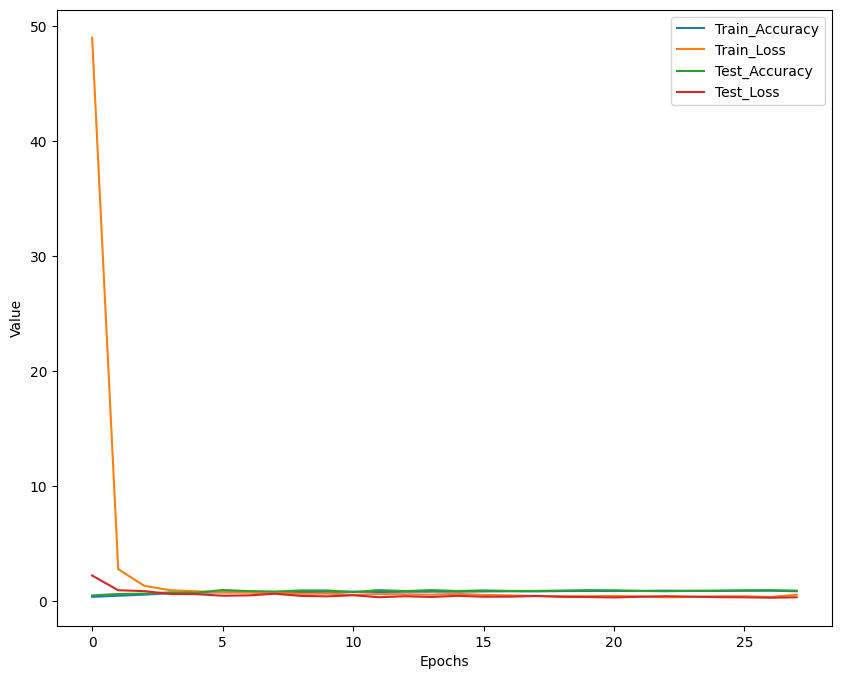

In [45]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

5/5 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.94        80
           1       1.00      1.00      1.00        17
           2       0.54      1.00      0.70        14
           3       1.00      0.67      0.80        21
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         8

    accuracy                           0.90       143
   macro avg       0.92      0.87      0.87       143
weighted avg       0.93      0.90      0.90       143



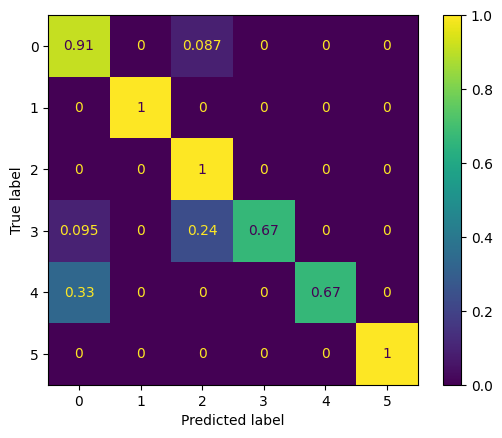

In [46]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

64/64 [==============================] - 1676s 26s/step


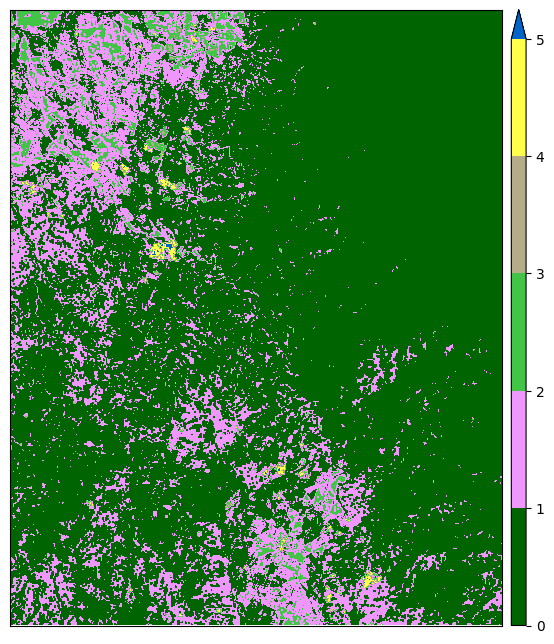

<Axes: >

In [47]:
# Predict image using the model
image_input = []
for x in range(len(FEATURES)):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(len(FEATURES), -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
# Ensure all color values in PALETTE are in valid hexadecimal format
PALETTE = ['#' + color if not color.startswith('#') else color for color in PALETTE]

cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

In [48]:
image_input.shape

(5196900, 22, 1)

In [49]:
image_vis.shape

(3, 2550, 2038)

In [50]:
unique, counts = np.unique(prediction, return_counts=True)
print("Unique classes in prediction:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} pixels")

Unique classes in prediction:
Class 0: 2398142 pixels
Class 1: 2210945 pixels
Class 2: 529869 pixels
Class 3: 14601 pixels
Class 4: 6206 pixels
Class 5: 37137 pixels


In [51]:
for i, band in enumerate(image_input.T):
    print(f"Band {i+1}: Min = {np.min(band):.2f}, Max = {np.max(band):.2f}, Mean = {np.mean(band):.2f}")

Band 1: Min = nan, Max = nan, Mean = nan


In [52]:
# Save file to drive
save_location = '/content/drive/MyDrive/s1s2_magdalena/'
name = 'LC_Magdalena_2020_CNN_poly.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()